## Imports & Setup

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, RandomHorizontalFlip
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from helpers import *
from architecture.EnsembleTwo import *

In [2]:
from torchsampler import ImbalancedDatasetSampler

In [3]:
torch.manual_seed(809)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                          RandomResizedCrop((size,size),scale=(0.8,1),ratio=(0.9,1.1)),

## Prepare Dataset

In [5]:
size = 44
batch_size = 256
transformation = Compose([RandomHorizontalFlip(), 
                          Resize((size, size)), ToTensor()])

In [6]:
root = '../reduced_dataset/cropped_augmented/'
train_data = create_dataset(root, transformation)
sampler = ImbalancedDatasetSampler(train_data)
train_loader = produce_loader(train_data, batch_size, sampler=sampler)
#reduced_dataset\cropped_augmented

In [7]:
root = '../reduced_dataset/cropped_augmented/'
test_data = create_dataset(root, transformation)
test_loader = produce_loader(test_data, batch_size)

In [8]:
root = '../reduced_dataset/cropped_augmented/'
val_data = create_dataset(root, transformation)
val_loader = produce_loader(val_data, batch_size)

[4249, 4981, 2839, 34, 4449, 3178, 3359, 1930, 5026]


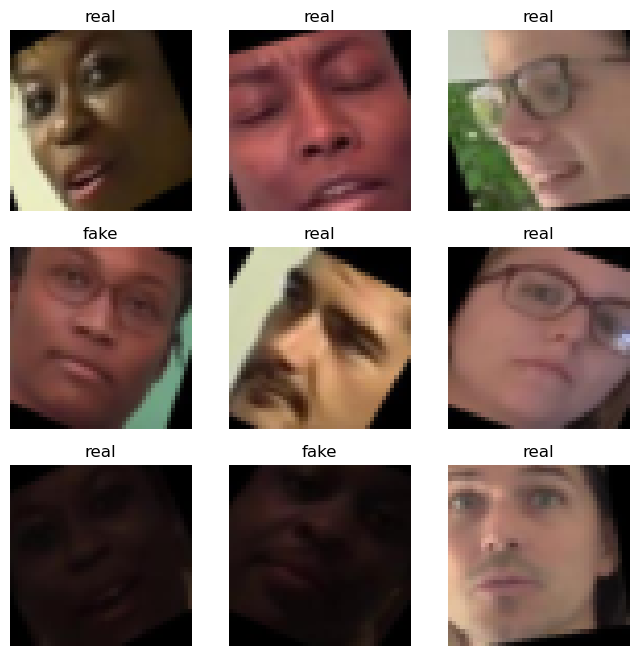

In [9]:
visualize_data(train_data)

[4712, 3755, 2643, 2651, 2003, 4496, 1283, 1133, 3395]


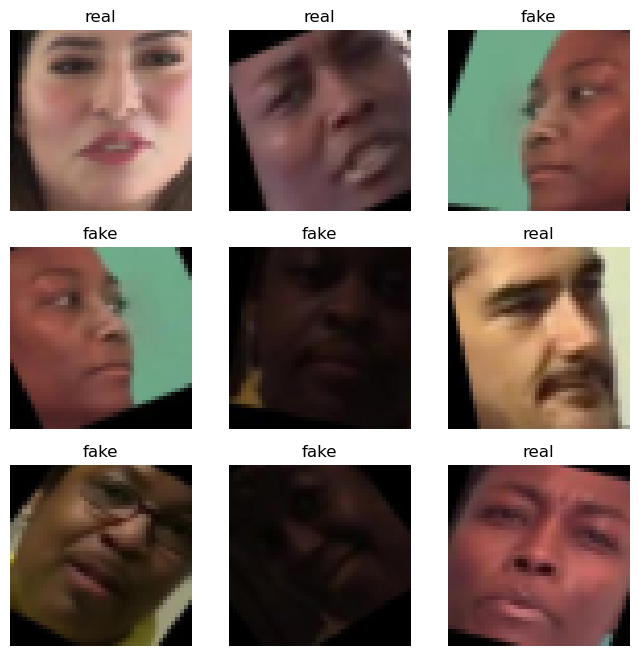

In [10]:
visualize_data(test_data)

## Initialize Model

In [11]:
def create_adam_optimizer(model, lr = 0.1, betas=(0.9, 0.999), amsgrad=False):
    return optim.Adam(model.parameters(), lr = lr, amsgrad=amsgrad, betas=betas)

In [12]:
from math import floor
# number of hidden layers and their sizes
hidden = [3, 256, 128, 64]

# kernel size of convolution layers
kernel_size = 3

# window size of maxpooling layer
window = 3

# calculate final size of image
channels = hidden[-1]
changed_img = floor( (size-(kernel_size-1)*(len(hidden)-1)) / window )

# calculate dimension of flattened image
flattened = channels*changed_img*changed_img

# final linear layers and their sizes
hidden_linear = [flattened, 512, 64]

In [13]:
model = DeepSearch(hidden=hidden, kernel_size=kernel_size,
                   window=window, hidden_linear=hidden_linear).to(device)
#model.load_state_dict(torch.load("./DeepSearch2_15epochs")["model_state_dict"])
print(model)

DeepSearch(
  (conv_combined): Sequential(
    (0): DeepSearchConv(
      (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (1): DeepSearchConv(
      (conv): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
    (2): DeepSearchConv(
      (conv): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout2d(p=0.5, inplace=False)
    )
  )
  (avgpool): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (linear_combined): Sequential(
    (0): DeepSearchLinear(
      (linear): Linear(in_features=9216, out_features=512, bias=True)
      (batch_norm): BatchNo

## Training Model

In [14]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [15]:
optimizer = create_adam_optimizer(model, lr=0.01)
#optimizer.load_state_dict(torch.load("./DeepSearch2_15epochs")["optimizer_state_dict"])

In [16]:
"""
train function params:
device
model - model to train
train_loader - training data loader
val_loader - validation data loader
optimizer - optimizer to use (allows for saving and reloading optimizer state to stop and resume training)
epochs
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)

returns lists of the training loss, training accuracy, validation loss and validation accuracy for plotting curves

"""
tl, ta, vl, va = train(device, model,
                       train_loader, val_loader, 
                       optimizer, epochs = 20, patience=5)
train_losses+=tl
train_accuracies+=ta
val_losses+=vl
val_accuracies+=va

Epoch 1/20, Batch number: 0, Cumulated accuracy: 0.546875
Epoch 1/20, Batch number: 5, Cumulated accuracy: 0.6158854166666666
Epoch 1/20, Batch number: 10, Cumulated accuracy: 0.6615767045454546
Epoch 1/20, Batch number: 15, Cumulated accuracy: 0.6748046875
--- Epoch 1/20: Train loss: 0.6122, Train accuracy: 0.6792
--- Epoch 1/20: Val loss: 0.6438, Val accuracy: 0.6843
Epoch 2/20, Batch number: 0, Cumulated accuracy: 0.78125
Epoch 2/20, Batch number: 5, Cumulated accuracy: 0.7259114583333334
Epoch 2/20, Batch number: 10, Cumulated accuracy: 0.7308238636363636
Epoch 2/20, Batch number: 15, Cumulated accuracy: 0.736572265625
--- Epoch 2/20: Train loss: 0.5548, Train accuracy: 0.7357
--- Epoch 2/20: Val loss: 0.5243, Val accuracy: 0.7506
Epoch 3/20, Batch number: 0, Cumulated accuracy: 0.75
Epoch 3/20, Batch number: 5, Cumulated accuracy: 0.7395833333333334
Epoch 3/20, Batch number: 10, Cumulated accuracy: 0.7492897727272727
Epoch 3/20, Batch number: 15, Cumulated accuracy: 0.748291015625

## Testing Model & Performance Curves

In [17]:
"""
test function params:
device
model - model to train
data_loader - chosen (testing) data loader
criterion - loss function to use (default is cross entropy)
autoencoder - autoencoder to use, if any (default is None)
get_predictions - if True, returns the list of true labels, the list of predictions made by the model, 
                  and values of the test loss and test accuracy (default is False)

by default, returns values of the test loss and test accuracy

"""
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)

Test loss: 0.2446, Test accuracy: 0.8929


Precision: 0.9116341030195382
Recall: 0.8554166666666667
F1 score: 0.8826311263972486


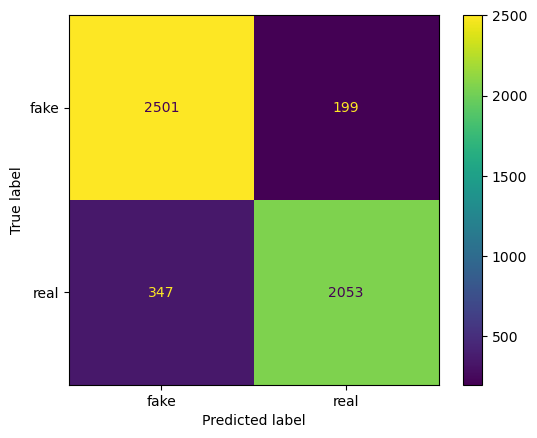

In [18]:
show_metrics(true_labels, model_preds)

In [19]:
model.load_state_dict(torch.load("./DeepSearch_checkpoint")["model_state_dict"])

<All keys matched successfully>

Test loss: 0.2435, Test accuracy: 0.8925
Precision: 0.9104609929078015
Recall: 0.8558333333333333
F1 score: 0.8823024054982818


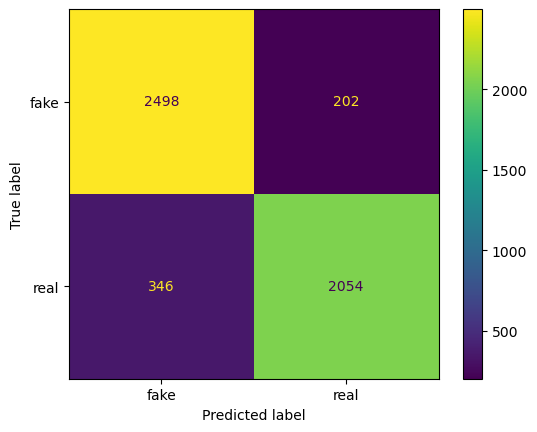

In [20]:
true_labels, model_preds, test_loss, test_accuracy = test(device, model, test_loader, get_predictions=True)
show_metrics(true_labels, model_preds)

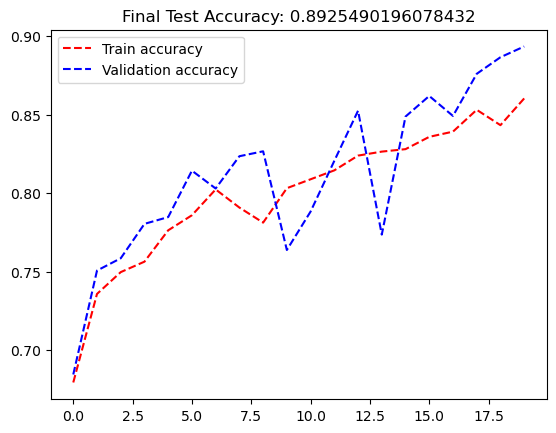

In [21]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

In [22]:
print(train_accuracies)

[0.6792156862745098, 0.735686274509804, 0.7496078431372549, 0.7562745098039215, 0.7762745098039215, 0.7858823529411765, 0.8023529411764706, 0.7907843137254902, 0.7811764705882352, 0.8031372549019608, 0.8088235294117647, 0.8145098039215686, 0.823921568627451, 0.8264705882352941, 0.8280392156862745, 0.8358823529411765, 0.8392156862745098, 0.8531372549019608, 0.8433333333333334, 0.8603921568627451]


In [23]:
print(val_accuracies)

[0.6843137254901961, 0.7505882352941177, 0.7584313725490196, 0.7803921568627451, 0.7847058823529411, 0.8143137254901961, 0.8029411764705883, 0.8235294117647058, 0.8266666666666667, 0.7637254901960784, 0.788235294117647, 0.8205882352941176, 0.8525490196078431, 0.7735294117647059, 0.8488235294117648, 0.8619607843137255, 0.8492156862745098, 0.876078431372549, 0.8866666666666667, 0.8935294117647059]


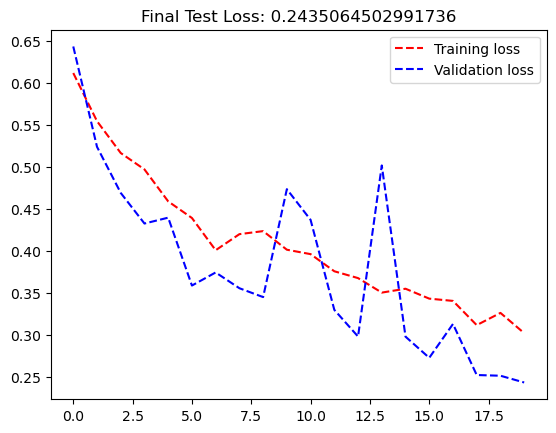

In [24]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

In [25]:
print(train_losses)

[0.6121687859296798, 0.5548287481069565, 0.5168712064623833, 0.49732318371534345, 0.45924944877624513, 0.4394736811518669, 0.40106487423181536, 0.4201983720064163, 0.4238369777798653, 0.40167558938264847, 0.3964171588420868, 0.37599664330482485, 0.36785963773727415, 0.3505867406725883, 0.355198372900486, 0.34339697659015656, 0.34068685621023176, 0.31183243095874785, 0.3264094844460487, 0.302280380576849]


In [26]:
print(val_losses)

[0.6437905518338084, 0.5242809846997261, 0.4693418674170971, 0.4328779175877571, 0.43987057358026505, 0.35899151060730217, 0.3745876334607601, 0.35579941011965277, 0.34524933714419603, 0.4738068513572216, 0.4372345039155334, 0.33003874905407427, 0.29823504788801075, 0.5020481951534748, 0.29809956103563306, 0.2729149252176285, 0.31320586800575256, 0.25239802319556476, 0.25155675541609523, 0.24351912373676896]


## Old curves, forgot to save values

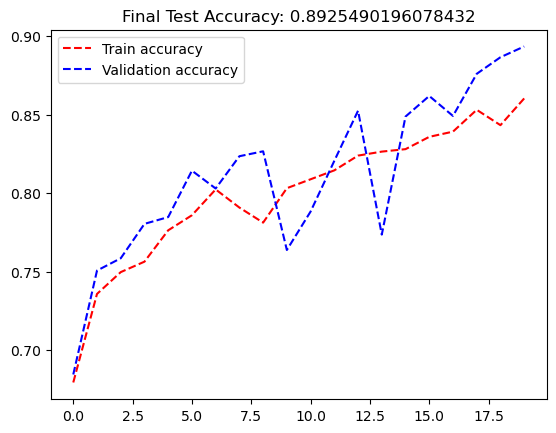

In [27]:
plt.plot(train_accuracies, "r--", label='Train accuracy')
plt.plot(val_accuracies, "b--", label='Validation accuracy')
plt.title("Final Test Accuracy: {}".format(test_accuracy))
plt.legend(loc='upper left')
plt.show()

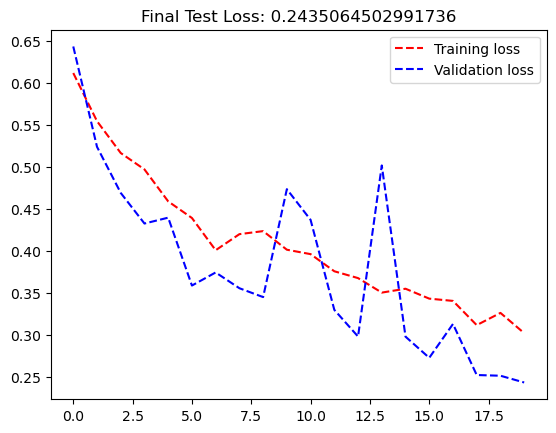

In [28]:
plt.plot(train_losses, "r--", label='Training loss')
plt.plot(val_losses, "b--", label='Validation loss')
plt.title("Final Test Loss: {}".format(test_loss))
plt.legend(loc='upper right')
plt.show()

## Viewing Model Predictions

In [29]:
test_loader2 = produce_loader(test_data, 1)

In [30]:
correct_list, wrong_list, true_labels2, model_preds2 = get_pictures_test(device, model, test_loader2)

Precision: 0.9146177916852928
Recall: 0.8525
F1 score: 0.8824671123571276


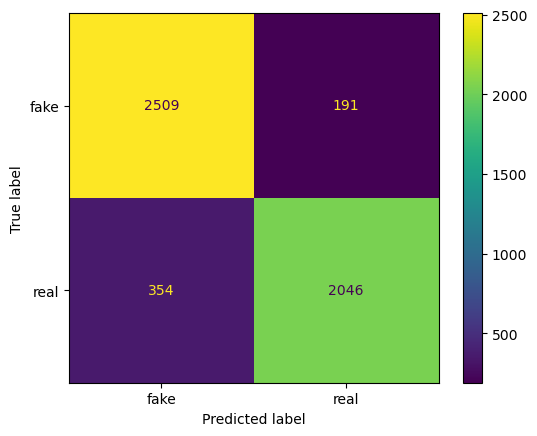

In [31]:
show_metrics(true_labels2, model_preds2)

[1823, 1716, 2462, 3971, 3896, 2655, 822, 2305, 1448, 3959, 1739, 4161, 2599, 3418, 76, 120, 959, 1483, 3665, 3797, 357, 4123, 378, 4230, 3044]


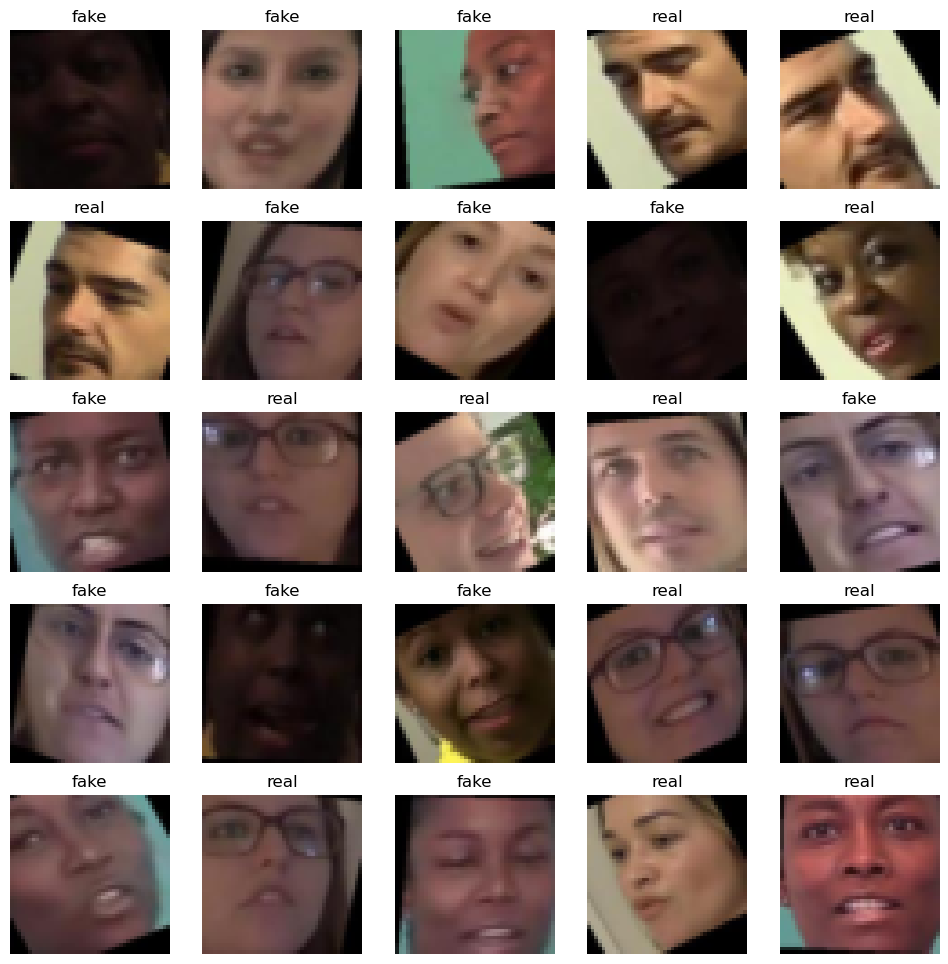

In [32]:
visualize_data(correct_list, (12,12), 5)

[169, 71, 440, 414, 103, 345, 539, 448, 32, 171, 475, 529, 311, 263, 396, 408, 382, 221, 258, 392, 332, 433, 277, 81, 58]


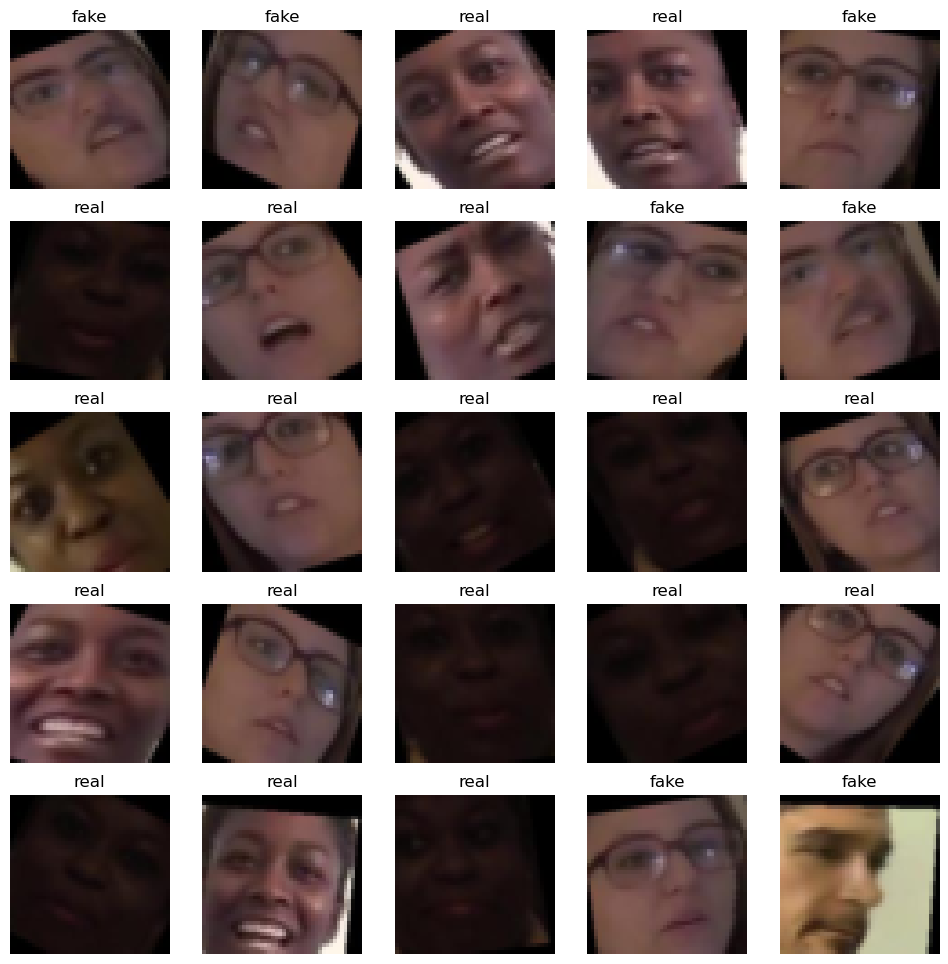

In [33]:
visualize_data(wrong_list, (12,12), 5)

## Saving Model

In [34]:
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()}, 
            './DeepSearch2_13epochs')

model_test = DeepLearn(kernels=kernels, hidden=hidden, kernel_size=kernel_size, window=window,
                   hidden_linear=hidden_linear, labels=labels).to(device)
model_test.load_state_dict(torch.load("./latest_16epochs")["model_state_dict"])